# This notebook shows the optimization to find the best spectral bands for unmixing a set of endmember spectra from a hyperspectral cube.

In [1]:
%pylab inline
from pysptools import abundance_maps
import random
import pandas as pd
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

Populating the interactive namespace from numpy and matplotlib


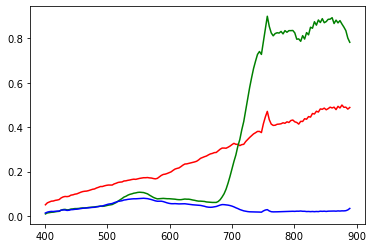

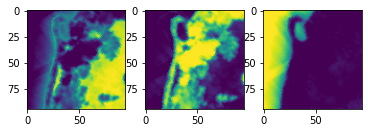

In [2]:
dataset = "samson"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T

# it is found the endmembers' spectra are normalised to 1, which is not the real spectra
# for the original spectra, see paper:
# Zhu, 2017, Hyperspectral Unmixing: Ground Truth Labeling, Datasets, Benchmark Performances and Survey.
spectra[0] = spectra[0] * 0.5
spectra[1] = spectra[1] * 0.9
spectra[2] = spectra[2] * 0.08

figure(1)
plot(wavelength, spectra[0], color='r')
plot(wavelength, spectra[1], color='g')
plot(wavelength, spectra[2], color='b')
plt.show()

figure(2)
subplot(1,3,1)
imshow(a_map[:,:,0])
subplot(1,3,2)
imshow(a_map[:,:,1])
subplot(1,3,3)
imshow(a_map[:,:,2])

In [3]:
def create_hypercube(a_map, spectra):
 
    '''
    Generate a hypercube.
    
    Inputs:
        a_map (N*M, L)
             
        spectra (L x Q array) - Array of 1D spectral respones for each pixel. Number of array members
            should be equal to the maximum value in im (L). Q is sample points in wavelength space.        
    
    N represents N*M!
    
    Output:
        hypercube (N*M, Q)
    '''

    N,_ = a_map.shape
    L,Q = spectra.shape

    hypercube = zeros((N,Q))
    
    for i in range(L):
        hypercube += outer(a_map[:,i],spectra[i]).reshape((N,Q))
    
    return hypercube

In [4]:
def pre_processing(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
            
    # Reshape the data array into 1d array,predicted_a_map
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # generate hypercube by predicted abundance map
    x = create_hypercube(predicted, endmembers)
    y_reshape = abundance_map.reshape((N*M,len(endmember_sig)))
    y = create_hypercube(y_reshape, endmembers)
    
    # Take rms.
    acc = x - y
    accuracy = sqrt(mean(acc**2))


    return accuracy, x, y,predicted,y_reshape

x is the predicted 
y is the ground truth

#  Set 1

In [5]:
center_wavelengths = [528., 684., 760.]

In [6]:
bandwidths = [20,20,20]

In [7]:
acc, X_predicted, X_groud_truth,Y_predicted, Y_groud_truth = pre_processing(hypercube, a_map, spectra,wavelength, center_wavelengths, bandwidths, return_predicted=False)

In [8]:
acc

0.143570357678378

In [9]:
X_predicted.shape

(9025, 156)

In [10]:
Y_predicted.shape

(9025, 3)

# Start ML Bolck

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


import tensorflow as tf
from keras import layers
from keras import models

In [12]:
X_predicted_half,X2_predicted_half,Y_predicted_half,Y2_predicted_half = train_test_split(X_predicted, Y_predicted, test_size=0.5)

In [13]:
x_train = np.vstack((X_predicted_half,X_groud_truth))

In [14]:
Y_predicted_half.shape

(4512, 3)

In [15]:
Y_groud_truth.shape

(9025, 3)

In [16]:
y_train = np.vstack((Y_predicted_half,Y_groud_truth))

In [17]:
x_test = X2_predicted_half

In [18]:
y_test = Y2_predicted_half

In [19]:
x_train.shape

(13537, 156)

In [20]:
y_train.shape

(13537, 3)

In [21]:
x_test.shape

(4513, 156)

In [22]:
y_test.shape

(4513, 3)

In [23]:
#savetxt("../Machine_Learning_ref_data/x.txt",X)

In [24]:
#savetxt("../Machine_Learning_ref_data/y.txt",Y)

In [25]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    
    tf.keras.layers.Dense(3,'softmax')
  ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [26]:
model = get_compiled_model()

In [27]:
history = model.fit(x_train,y_train, epochs=30)

Epoch 1/30
424/424 [==============================] - 0s 780us/step - loss: 0.6503 - accuracy: 0.9402
Epoch 2/30
424/424 [==============================] - 0s 812us/step - loss: 0.6426 - accuracy: 0.9706
Epoch 3/30
424/424 [==============================] - 0s 821us/step - loss: 0.6424 - accuracy: 0.9745
Epoch 4/30
424/424 [==============================] - 0s 819us/step - loss: 0.6423 - accuracy: 0.9760
Epoch 5/30
424/424 [==============================] - 0s 773us/step - loss: 0.6422 - accuracy: 0.9798
Epoch 6/30
424/424 [==============================] - 0s 777us/step - loss: 0.6422 - accuracy: 0.9795
Epoch 7/30
424/424 [==============================] - 0s 778us/step - loss: 0.6421 - accuracy: 0.9807
Epoch 8/30
424/424 [==============================] - 0s 786us/step - loss: 0.6421 - accuracy: 0.9815
Epoch 9/30
424/424 [==============================] - 0s 834us/step - loss: 0.6420 - accuracy: 0.9834
Epoch 10/30
424/424 [==============================] - 0s 779us/step - loss: 0.642

In [28]:
loss,acc = model.evaluate(x_test,y_test, verbose=1)

142/142 [==============================] - 0s 492us/step - loss: 0.6750 - accuracy: 0.9845


In [29]:
print(loss,acc)

0.6750267744064331 0.9844892621040344


In [30]:
#model.save('my_model_amazing_acc_0.99.h5')

In [31]:
# model=load_model("my_model_.hdf5")

In [32]:
training_loss = history.history['loss']

In [33]:
training_acc = history.history['accuracy']

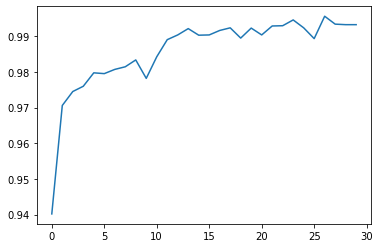

In [34]:
plot(training_acc)

#  Set 2

In [35]:
center_wavelengths = [613, 565, 891] 

In [36]:
bandwidths = [20,20,20]

In [37]:
acc, X_predicted, X_groud_truth,Y_predicted, Y_groud_truth = pre_processing(hypercube, a_map, spectra,wavelength, center_wavelengths, bandwidths, return_predicted=False)

In [38]:
acc

0.1342566760253208

In [39]:
X_predicted.shape

(9025, 156)

In [40]:
Y_predicted.shape

(9025, 3)

# Start ML Bolck

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


import tensorflow as tf
from keras import layers
from keras import models

In [42]:
X_predicted_half,X2_predicted_half,Y_predicted_half,Y2_predicted_half = train_test_split(X_predicted, Y_predicted, test_size=0.5)

In [43]:
x_train = np.vstack((X_predicted_half,X_groud_truth))

In [44]:
Y_predicted_half.shape

(4512, 3)

In [45]:
Y_groud_truth.shape

(9025, 3)

In [46]:
y_train = np.vstack((Y_predicted_half,Y_groud_truth))

In [47]:
x_test = X2_predicted_half

In [48]:
y_test = Y2_predicted_half

In [49]:
x_train.shape

(13537, 156)

In [50]:
y_train.shape

(13537, 3)

In [51]:
x_test.shape

(4513, 156)

In [52]:
y_test.shape

(4513, 3)

In [53]:
#savetxt("../Machine_Learning_ref_data/x.txt",X)

In [54]:
#savetxt("../Machine_Learning_ref_data/y.txt",Y)

In [55]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    
    tf.keras.layers.Dense(3,'softmax')
  ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [56]:
model = get_compiled_model()

In [57]:
history = model.fit(x_train,y_train, epochs=30)

Epoch 1/30
424/424 [==============================] - 0s 753us/step - loss: 0.6518 - accuracy: 0.9293
Epoch 2/30
424/424 [==============================] - 0s 748us/step - loss: 0.6431 - accuracy: 0.9755
Epoch 3/30
424/424 [==============================] - 0s 748us/step - loss: 0.6431 - accuracy: 0.9759
Epoch 4/30
424/424 [==============================] - 0s 774us/step - loss: 0.6429 - accuracy: 0.9799
Epoch 5/30
424/424 [==============================] - 0s 782us/step - loss: 0.6428 - accuracy: 0.9823
Epoch 6/30
424/424 [==============================] - 0s 776us/step - loss: 0.6427 - accuracy: 0.9826
Epoch 7/30
424/424 [==============================] - 0s 758us/step - loss: 0.6427 - accuracy: 0.9826
Epoch 8/30
424/424 [==============================] - 0s 754us/step - loss: 0.6427 - accuracy: 0.9832
Epoch 9/30
424/424 [==============================] - 0s 792us/step - loss: 0.6427 - accuracy: 0.9828
Epoch 10/30
424/424 [==============================] - 0s 796us/step - loss: 0.642

In [58]:
loss,acc = model.evaluate(x_test,y_test, verbose=1)

142/142 [==============================] - 0s 503us/step - loss: 0.6751 - accuracy: 0.9856


In [59]:
print(loss,acc)

0.6750688552856445 0.9855971932411194


In [60]:
#model.save('my_model_amazing_acc_0.99.h5')

In [61]:
# model=load_model("my_model_.hdf5")

In [62]:
training_loss_2 = history.history['loss']

In [63]:
training_acc_2 = history.history['accuracy']

In [64]:
x_axis = range(1,31)

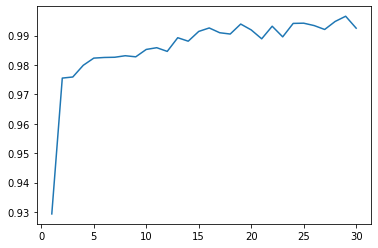

In [65]:
plot(x_axis,training_acc_2)


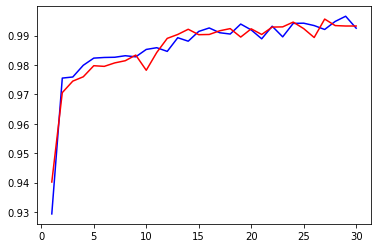

In [66]:
plot(x_axis,training_acc_2,'blue')
plot(x_axis,training_acc,'red')

Text(0.5, 1.0, 'a_map noise reduction using NN (Samson)')

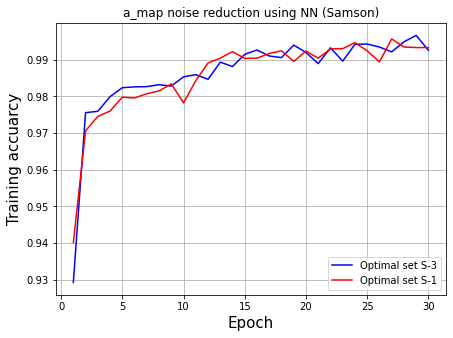

In [73]:

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)

ax.plot(x_axis,training_acc_2,'b',label = 'Optimal set S-3')
ax.plot (x_axis,training_acc,'r',label = 'Optimal set S-1')

ax.grid()
ax.legend(loc=4)

ax.set_xlabel('Epoch',fontsize=15)
ax.set_ylabel("Training accuarcy",fontsize=15)
title('a_map noise reduction using NN (Samson)')